## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm == 0.4.5  # 0.3.2 does not work in Colab
    !git clone https: // github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')

### Define utils

In [5]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    image = image.detach().cpu()
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def show_map(m, title=""):
    assert len(m.shape) == 2
    m = m.detach().cpu()
    # m = plt.Normalize()(m)
    plt.imshow(m, cmap="viridis")
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    pprint(msg)
    return model


def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    result = model.inference(x.float())
    pprint(result)
    x = torch.einsum('nchw->nhwc', x)
    y = result["preds"]
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    loss_map = result["loss_map"].detach().cpu()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 3, 1)
    show_image(x[0], "original")

    plt.subplot(1, 3, 2)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 3, 3)
    show_map(loss_map[0], "loss map")

    plt.show()

### Load an image

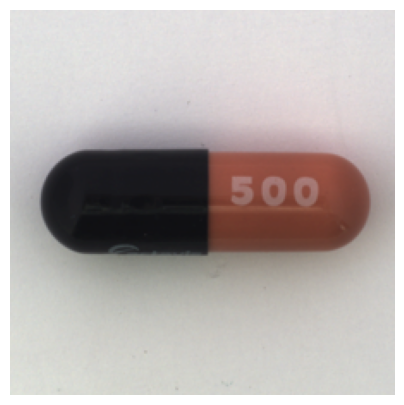

In [6]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
# img = Image.open("../../data/capsule/test/bad/poke_000.png")
img = Image.open("../../data/capsule/test/good/000.png")
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [12]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
import os

chkpt_dir = "../output_dir/checkpoint-3300.pth"
assert os.path.exists(chkpt_dir)
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch14')
print('Model loaded.')


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

### Run MAE on the image

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
import models_mae

print('MAE with pixel reconstruction:')
run_one_image(torch.tensor(img, device="cuda"), model_mae.to("cuda"))

MAE with pixel reconstruction:


NameError: name 'model_mae' is not defined

### Load another pre-trained MAE model

In [35]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https: // dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

--2024-03-11 13:41:13--  ftp://https/
           => '.listing'
Resolving https (https)... failed: No such host is known. .
wget: unable to resolve host address 'https'
//: Scheme missing.
--2024-03-11 13:41:16--  http://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.236.98, 18.239.236.19, 18.239.236.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.236.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: 'mae_visualize_vit_large_ganloss.pth'

     0K .......... .......... .......... .......... ..........  0%  880K 24m23s
    50K .......... .......... .......... .......... ..........  0% 1.84M 17m52s
   100K .......... .......... .......... .......... ..........  0% 2.20M 15m6s
   150K .......... .......... .......... .......... ..........  0% 6.55M 12m7s
   200K .......... .......... ..........

AssertionError: 

### Run MAE on the image

MAE with extra GAN loss:


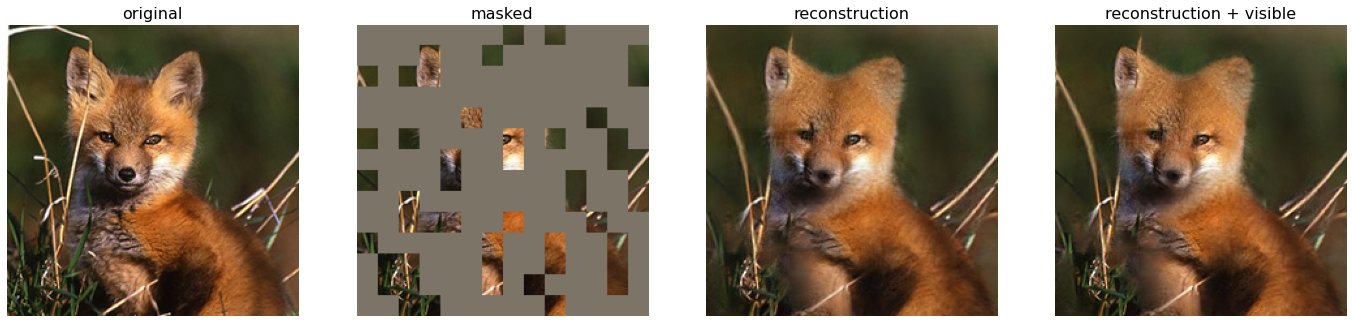

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)